# Pokemon Stat Predictor

## Methodology

#### Introduction

This is a project that takes known data about Pokemon species from the Pokemon video games and creates a database of average stats based on typing. The data is formatted to look at the Base Stat Totals (BST) of Pokemon species, cross-comparing with the typing of a Pokemon as well as its evolutionary stage.

The data used for this project was imported from Bulbapedia (https://bulbapedia.bulbgarden.net) and encorporates Pokemon through generation VII. Bulbapedia was chosen for its large number of html tables on Pokemon and for its mostly consistent formatting across the site.

There are several areas where we have to clean or reformat the data to ensure that we are not losing key pieces of information. More detail on those instances is given next to the code that cleans the data.

This notebook contains examples of webscraping, data cleaning, use of pandas dataframes, and chart generation with seaborn.

This notebook project was inspired by this post from Medium on building a Pokedex: https://towardsdatascience.com/web-scraping-html-tables-with-python-c9baba21059

#### Exclusions from the dataset (Pokemon domain knowledge)

At the start of this project, I knew I wanted to exclude Mega Pokemon from my calculations. Mega Pokemon, introduced in Gen VI, have inflated stats compared to non-mega pokemon and would skew the data towards those species or type combinations that have received Mega Evolutions.

I also made the choice to include all Alolan variant Pokemon. These are Pokemon species from Gen I that have been given new type combinations in Gen VII. I believe this increases the overall diversity of type combinations.

After exploring the data, I also decided to remove the following data points from my data sets:

* Ultra Beasts - introduced in Gen VII, these pokemon have high BSTs (570) and, like Mega Pokemon, skew averages towards those type combinations that have received Ultra Beasts.

* Legendary Pokemon - there are two complications with Legendary Pokemon. First, like Mega Pokemon and Ultra Beasts, they have high stats (BSTs at 600 or higher). Second, there is a subset of Legendary Pokemon that have a value of 100 for each of their stats (Mew, Celebi, Jirachi, etc); the lack of variance in the individual stats and trend towards Psychic-Type would make analyzing the data difficult.

* Special Pokemon - over the course of generations, special variants have been added. These include Partner Pikachu and Partner Eevee from the Let's Go games and the Ash-Greninja.

For all other variants (Wormadam, Rotom, Aegislash, etc), I have left them in the data to represent the full data set as accurately as possible.

## Imports and Functions

In [74]:
#imports
from lxml import html
import requests
import re
import pandas as pd
import seaborn as sns
import numpy as np

#do I use this in the notebook???
from matplotlib import pyplot

In [75]:
#Function  for cleaning bulbapedia tables.
#This function definition needs to be cleaned up!
def bulbapedia_table_cleaner(input_lst):
    '''This function takes tr data separated by newline characters and modifies it into a comma separated
    Takes tr data from bulbapedia format and returns a dataframe.
    Expects a list to be turned into list of lists to be turned into df rows.
    input_lst: list with tr data. Should be a list with elements separated by commas.'''
    middle_lst = []
    last_lst = []
    for el in input_lst:
        cleaned = el.replace('\n\n ', ',')
        cleaned_2 = cleaned.replace(',,', ',')
        cleaned_3 = cleaned_2.replace('\n', '')

        middle_lst.append(cleaned_3)

    for el in middle_lst:
        split = el.split(',')
        last_lst.append(split)
    
    output_df = pd.DataFrame(last_lst)

    return output_df

In [76]:
#copied from below. Make sure to delete the extra cell if needed!
def bulbapedia_form_finder(row):
    if row['Variant'] == None:
        value = row['Pokemon']
    elif "Mega" in row['Variant']:
        value = "Mega"
    elif "Alolan" in row['Variant']:
        value = "Alolan "+row['Pokemon']
    elif "Wormdam" in row['Pokemon']:
        value = row['Pokemon']+row['Variant'].str.split(' ')
    else:
        value = row['Pokemon']
    return value

In [77]:
#copied from below. Make sure to delete the extra cell if needed!
def makes_list_of_lists(input_lst):
    output_list = []

    for el in input_lst:
        list_split = el.split(",")
        output_list.append(list_split)
    return output_list

## Gathering Data

#### Constructing the First Table (BST)

This is our primary table for the analysis - it holds a list of each Pokemon species and the numeric values for their stats (HP, Attack, Defense, Special Attack, Special Defense, and Speed) as well as the sum of their stats (the Base Stat Total, or BST) and their average stat value.

In [78]:
#First Table Download
url = 'https://bulbapedia.bulbagarden.net/wiki/List_of_Pok%C3%A9mon_by_base_stats_(Generation_VII-present)'
page = requests.get(url)
tree = html.fromstring(page.content)

You need a bit of HTML experience to identify the elements you want to scrape using the requests and html packages. This is a screen shot of the elements on the webpage above, showing us that we are interested in the "tr" elements

<img src="C:\Users\nmanh\OneDrive\Desktop\bulbapedia pokemon bst inspect element.png",width=250,height=250>

In [79]:
#Parse tr elements of the HTML for your page
tr_elements = tree.xpath('//tr')

In [80]:
#Checks for element length. Helps determine if you scraped more than one table (<tr> element) from the webpage.
#I checked the first 12 and last 12 elements of the table. You can un-comment out the below lines to 
# see the length of the elements. Based on this sampling, it looks like the length of 11 is the main
# main table from our website.
[len(el) for el in tr_elements[:12]]
#[len(el) for el in tr_elements[-13:-1]]

[1, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]

In [81]:
pkmn_bst_table_rows = []

for el in tr_elements:
    if len(el) == 11:
        row = el.text_content()
        pkmn_bst_table_rows.append(row)

In [ ]:
#Run this cell to see the default text in the table from Bulbapedia.
#You should see a lot of newline characters (\n), which is how Bulbapedia separates the cells of its table. 
#The bulbapedia_table_cleaner function is designed to specifically clean up a table with these characters.
pkmn_bst_table_rows

In [82]:
#Declare new, empty dataframe for function
pkmn_bst_df = pd.DataFrame()

In [83]:
pkmn_bst_df = bulbapedia_table_cleaner(pkmn_bst_table_rows)

In [ ]:
pkmn_bst_df.head()

In [84]:
#Update the df to get the column headers formatted cleanly

#update all text data to lowercase
pkmn_bst_df = pkmn_bst_df.apply(lambda row: row.astype(str).str.lower())

#Promote first row of df to headers
header_row = pkmn_bst_df.iloc[0]
pkmn_bst_df = pkmn_bst_df[1:]
pkmn_bst_df.columns = header_row

#rename column to remove special é character in Pokémon
pkmn_bst_df.rename(columns = {
    "pokémon":"pokemon"
}, inplace=True)

In [85]:
pkmn_bst_df.head()

,#,pokemon,hp,attack,defense,sp. attack,sp. defense,speed,total,average
1,001,bulbasaur,45,49,49,65,65,45,318,53
2,002,ivysaur,60,62,63,80,80,60,405,67.5
3,003,venusaur,80,82,83,100,100,80,525,87.5
4,003,venusaur (mega venusaur),80,100,123,122,120,80,625,104.17
5,004,charmander,39,52,43,60,50,65,309,51.5


#### Constructing the Second Table (Evolutionary Stage)

Pokemon go through a process known as "evolution" by which they transform into new species. As Pokemon evolve, their stats increase. Because of this, we want to know where in the evolutionary chain each Pokemon species is.

I was unable to find a source of this information in an extractable format online, so I generated my own table. I used the following stages in my classification: baby, basic, stage 1, stage 2, mega, legendary, ultra beast.

I used the same BST table as my starting point to ensure I would have an exact match for each row in my first table.

In [86]:
#open csv file with Pokemon stage data
stages_raw = open("pokemon stages.csv", "r")
stages_read = stages_raw.read()
stages_split = stages_read.split("\n")

In [87]:
stages_split

['dex #,Pokemon,Stage',
 '1,Bulbasaur,basic',
 '2,Ivysaur,stage 1',
 '3,Venusaur,stage 2',
 '3,Venusaur (Mega Venusaur),mega',
 '4,Charmander,basic',
 '5,Charmeleon,stage 1',
 '6,Charizard,stage 2',
 '6,Charizard (Mega Charizard X),mega',
 '6,Charizard (Mega Charizard Y),mega',
 '7,Squirtle,basic',
 '8,Wartortle,stage 1',
 '9,Blastoise,stage 2',
 '9,Blastoise (Mega Blastoise),mega',
 '10,Caterpie,basic',
 '11,Metapod,stage 1',
 '12,Butterfree,stage 2',
 '13,Weedle,basic',
 '14,Kakuna,stage 1',
 '15,Beedrill,stage 2',
 '15,Beedrill (Mega Beedrill),mega',
 '16,Pidgey,basic',
 '17,Pidgeotto,stage 1',
 '18,Pidgeot,stage 2',
 '18,Pidgeot (Mega Pidgeot),mega',
 '19,Rattata,basic',
 '19,Rattata (Alolan Rattata),basic',
 '20,Raticate,stage 1',
 '20,Raticate (Alolan Raticate),stage 1',
 '21,Spearow,basic',
 '22,Fearow,stage 1',
 '23,Ekans,basic',
 '24,Arbok,stage 1',
 '25,Pikachu,basic',
 '25,Pikachu (Partner Pikachu),basic',
 '26,Raichu,stage 1',
 '26,Raichu (Alolan Raichu),stage 1',
 '27,Sand

In [88]:
pkmn_stages_data = makes_list_of_lists(stages_split)

In [89]:
pkmn_stages_df = pd.DataFrame(pkmn_stages_data)

In [ ]:
pkmn_stages_df.head()

In [90]:
#update all text data to lowercase
pkmn_stages_df = pkmn_stages_df.apply(lambda row: row.astype(str).str.lower())

#Promote first row of df to headers
header_row = pkmn_stages_df.iloc[0]
pkmn_stages_df = pkmn_stages_df[1:]
pkmn_stages_df.columns = header_row

In [91]:
pkmn_stages_df.head()

,dex #,pokemon,stage
1,1,bulbasaur,basic
2,2,ivysaur,stage 1
3,3,venusaur,stage 2
4,3,venusaur (mega venusaur),mega
5,4,charmander,basic


#### Constructing the Third Table (Pokemon Types)

Similarly to evolutionary stage, Pokemon can be classified based on their type (an elemental affinity).

This information can also be scraped from bulbapedia using the same method that was used to construct our first table.

In [92]:
#Third Table Download
url_2 = 'https://bulbapedia.bulbagarden.net/wiki/List_of_Pok%C3%A9mon_by_index_number_(Generation_VII)'
page_2 = requests.get(url_2)
tree_2 = html.fromstring(page_2.content)

tr_elements_2 = tree_2.xpath('//tr')

In [93]:
#Checks for element length. Helps determine if you scraped more than one table.
#I checked the first 12 and last 12 elements of the table. You can un-comment out the below lines to 
# see the length of the elements. Based on this sampling, it looks like the length of 6 is the main
# main table from our website.
[len(el) for el in tr_elements_2[:12]]
#[len(el) for el in tr_elements_2[-13:-1]]

[2, 3, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6]

In [94]:
pkmn_types_table_rows = []

for el in tr_elements_2:
    if len(el) == 6:
        row = el.text_content()
        pkmn_types_table_rows.append(row)

In [ ]:
#Interestingly, the type table that we scraped did not include a header row.
#Again, we see the use of the newline characters (\n) to separate cells in the table on the bulbapedia webpage.
pkmn_types_table_rows

In [95]:
#Here I create a new list to function as the table headers for our pkmn_type_table_df.
#This will help keep our data clear as we edit it and join it later on.
pkmn_types_table_header = ['bulb_index,nat_dex,pokemon,type1,type2']

pkmn_types_table_rows = pkmn_types_table_header+pkmn_types_table_rows

In [ ]:
pkmn_types_table_rows

In [96]:
pkmn_types_df = bulbapedia_table_cleaner(pkmn_types_table_rows)

In [ ]:
pkmn_types_df.head()

In [97]:
#update all text data to lowercase
pkmn_types_df = pkmn_types_df.apply(lambda row: row.astype(str).str.lower())

#Promote first row of df to headers
header_row = pkmn_types_df.iloc[0]
pkmn_types_df = pkmn_types_df[1:]
pkmn_types_df.columns = header_row

In [98]:
pkmn_types_df.head()

,bulb_index,nat_dex,pokemon,type1,type2
1,001,001,bulbasaur,grass,poison
2,002,002,ivysaur,grass,poison
3,003,003,venusaur,grass,poison
4,004,004,charmander,fire,fire
5,005,005,charmeleon,fire,fire


#### Merging Dataframes

At this point, I am going to merge my BST dataframe and my stages dataframe together. Because the stages dataframe was generated from the same webpage data as the BST dataframe, I know that these rows will match 1:1.

I am not merging in our types dataframe because it needs to be cleaned and edited before it can be merged correctly.

In [99]:
pkmn_bst_stages_df = pd.merge(pkmn_bst_df, pkmn_stages_df, how='left', left_on='pokemon', right_on='pokemon')

In [100]:
#rearrange columns for clarity
#pkmn_bst_stages_df = pkmn_bst_stages_df[['dex #', 'Pokemon', 'Stage', 'HP', 'Attack', 'Defense', 
#                                         'Sp. Attack', 'Sp. Defense', 'Speed', 'Total', 'Average']]

pkmn_bst_stages_df.head()

,#,pokemon,hp,attack,defense,sp. attack,sp. defense,speed,total,average,dex #,stage
0,001,bulbasaur,45,49,49,65,65,45,318,53,1,basic
1,002,ivysaur,60,62,63,80,80,60,405,67.5,2,stage 1
2,003,venusaur,80,82,83,100,100,80,525,87.5,3,stage 2
3,003,venusaur (mega venusaur),80,100,123,122,120,80,625,104.17,3,mega
4,004,charmander,39,52,43,60,50,65,309,51.5,4,basic


## Data Exploration 

The first data issue we come across in our pkmn_bst_df is the inclusion of Mega Pokemon (see Row 4 - Mega Venusaur above). As mentioned above, we want to exclude Mega Pokemon because they are outliers in our dataset. 

However, there is another issue - Pokemon species that have only alternate forms (formes). You can run the following cells to see some examples.

There is a discrepancy in how bulbapedia has listed pokemon between  their two tables.

In the bst table, pokemon and their alternate forms are listed (eg. "Venausaur" and "Venusaur (Mega Venusaur)"). This is not an issue for Mega Pokemon or Alolan Forms because the default or original form is captured.

However, this is an issue for pokemon that only have "alternate" forms, such as Deoxys and Wormadam. This causes these pokemon to be entirely excluded from the merged dataframe because there are no matching values between the bst table and the type table.

Run the cell below to see an example of the Deoxys data from the bst table.

This project will attempt to exculde all megas from the calculations, but will include Alolan forms and alternate forms.

In [ ]:
#See rows 479 - 481 for Wormadam forms - notice the stat distribution is different based on the variant.
pkmn_bst_stages_df[474:484]

In [ ]:
#See rows 800-803 for Pumpkaboo variants and rows 804-807 for Gourgeist variants.
#Notice stat variations across the different variants here as well.
pkmn_bst_stages_df[798:808]

In [ ]:
#creating a new df with all of the special variants listed
pkmn_variants_df = pkmn_bst_stages_df[(pkmn_bst_stages_df.pokemon).str.contains(r'([\(])')]

In the following dataframe, you can see all of the different variants that Pokemon species have (125 rows of our first table are variants).

To recap - I am excluding certain Pokemon Variants to keep the dataset standardized:

Exclude:

* Mega Pokemon (ex Mega Venusaur, Mega Charizard X, Mega Charizard Y, etc)

* Legendary Pokemon (ex Kyurem (White Kyurem), Meloetta (Aria Forme), Melotta (Pirouette Forme), etc)

* Ultra Beasts (None shown in pkmn_variants_df)

* Special Pokemon (ex Partner Pikachu, Ash-Greninga, etc)

Include:

* Alolan Variants (ex Alolan Rattata, Alolan Raticate, Alolan Raichu)

* Non-legendary Form Variants (ex Aegislash (Shield Forme), Aegislash (Blade Forme), Pumpkaboo (Small Size), etc)

In [ ]:
pkmn_variants_df

However, there is another issue with our data - the two tables we got from Bulbapedia are constructed inconsistently. We will examine these tables and then make some modifications to make sure we are capturing data correctly before we merge in our pkmn_types_df.

In [ ]:
pkmn_bst_stages_df.shape

In [ ]:
pkmn_types_df.shape

You can see that there is almost a 100 row difference between the two tables we pulled from Bulbapedia!

There are various reasons for this discrepancy. Below I will do some more data exploration and cleaning to get our two tables to be a better match before merging.

In running the head method on each table, we already see one suspected source of differences - our pkmn_types_df lacks Mega Pokemon (compare the 4th row of each table).

We can confirm that this is the case using the str.contains method, similarly to how we created our pkmn_variants_df

In [ ]:
pkmn_bst_stages_df.head()

In [ ]:
pkmn_types_df.head()

In [101]:
pkmn_mega_types_df = pkmn_types_df[(pkmn_types_df.pokemon).str.contains(r'(mega)')]

C:\Users\nmanh\Miniconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


In [102]:
#You should have 2 rows in this table for the Pokemon Meganium and Yanmega
pkmn_mega_types_df

,bulb_index,nat_dex,pokemon,type1,type2
154,09a,154,meganium,grass,grass
471,1d5,469,yanmega,bug,flying


In [103]:
#We can perform a similar test for Alolan Pokemon, which I know 
# are excluded from the types table on Bulbapedia by reviewing the webpage.

pkmn_alolan_types_df = pkmn_types_df[(pkmn_types_df.pokemon).str.contains(r'(alolan)')]

#This table should be empty.
pkmn_alolan_types_df

C:\Users\nmanh\Miniconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  after removing the cwd from sys.path.


,bulb_index,nat_dex,pokemon,type1,type2


In addition to the Mega Pokemon and Alolan Pokemon, there are additional irregularities in our data. You may recall when we looked at Wormadam in our pkmn_bst_stages_df and saw three listings; when we search for the same Pokemon in our pkmn_types_df, we do not see the same three listings.

Below you can see that there are again three rows for Wormadam, but they do not have the additional forms (cloaks) listed behind them.

This is the same case for Pokemon like Rotom (multiple forms with different typing) and for Pokemon like Lycanrock (multiple forms with the same typing).

In [ ]:
pkmn_bst_stages_df[477:482]

In [ ]:
pkmn_types_df[411:416]

In [104]:
#Selecting all rows from our pkmn_types_df with duplicate values in the column Pokemon.
pkmn_names = pkmn_types_df['pokemon']

pkmn_duplicated_types_df = pkmn_types_df[pkmn_names.isin(pkmn_names[pkmn_names.duplicated()])]

pkmn_duplicated_types_df

,bulb_index,nat_dex,pokemon,type1,type2
413,19d,413,wormadam,bug,grass
414,19d,413,wormadam,bug,ground
415,19d,413,wormadam,bug,steel
481,1df,479,rotom,electric,ghost
482,1df,479,rotom,electric,fire
483,1df,479,rotom,electric,water
484,1df,479,rotom,electric,ice
485,1df,479,rotom,electric,flying
486,1df,479,rotom,electric,grass
499,1ec,492,shaymin,grass,grass


The new pkmn_duplicated_types_df shows us a couple of interesting things:

* Not all legendary forms are listed in multiple - Only Shaymin and Meloetta appear here. You can compare this to the Unova Genies (pkmn_bst_stages_df[721:731]).

* There are some pokemon that are duplicated in the pkmn_bst_types_df that have the same typing between their forms (Wishiwashi, Lycanrock, etc).

In both these cases, we do not need to worry. All legendary Pokemon will be filtered out of the dataset prior to joining in our types and for pokemon that share typing between their forms, we only need one value in our pkmn_types_df to join into our pkmn_bst_stages_df.

The difficult outliers in the data set are pokemon that have type differences between their forms: Wormadam, Rotom, and Darmanitan. In order to make sure they are properly recorded, I will update the pkmn_types_df to have their names shown as they are in the pkmn_bst_stages_df - with their forms listed in parentheses.

In [105]:
#create a dataframe for Pokemon with different typing between forms
pkmn_forms_types_df = pd.DataFrame([[413, 'wormadam (plant cloak)', 'bug', 'grass'],
                                   [413, 'wormadam (sandy cloak)', 'bug', 'ground'],
                                   [413, 'wormadam (trash cloak)', 'bug', 'steel'],
                                    [479, 'rotom (heat rotom)', 'electric', 'fire'],
                                    [479, 'rotom (wash rotom)', 'electric', 'water'],
                                    [479, 'rotom (frost rotom)', 'electric', 'ice'],
                                    [479, 'rotom (fan rotom)', 'electric', 'flying'],
                                    [479, 'rotom (mow rotom)', 'electric', 'grass'],
                                    [555, 'darmanitan (standard mode)', 'fire', 'fire'],
                                    [555, 'darmanitan (zen mode)', 'fire', 'psychic'],
                                    [681, 'aegislash (shield forme)', 'steel', 'ghost'],
                                    [681, 'aegislash (blade forme)', 'steel', 'ghost'],
                                    [745, 'lycanroc (midday form)', 'rock', 'rock'],
                                    [745, 'lycanroc (midnight form)', 'rock', 'rock'],
                                    [745, 'lycanroc (dusk form)', 'rock', 'rock'],
                                    [746, 'wishiwashi (solo form)', 'water', 'water'],
                                    [746, 'wishiwashi (school form)', 'water', 'water'],
                                    [774, 'minior (meteor form)', 'rock', 'flying'],
                                    [774, 'minior (core form)', 'rock', 'flying'],
                                    [710, 'pumpkaboo (average size)', 'ghost', 'grass'],
                                    [711, 'gourgeist (average size)', 'ghost', 'grass']
                                   ], 
                                   columns=['nat_dex','pokemon','type1','type2'])

In [106]:
#create a dataframe for Alolan Variant Pokemon
alolan_types_df = pd.DataFrame([[19, 'rattata (alolan rattata)', 'dark', 'normal'], 
                              [20, 'raticate (alolan raticate)', 'dark', 'normal'], 
                              [26, 'raichu (alolan raichu)', 'electric', 'psychic'],
                              [27, 'sandshrew (alolan sandshrew)', 'ice', 'steel'],
                              [28, 'sandslash (alolan sandslash)', 'ice', 'steel'],
                              [37, 'vulpix (alolan vulpix)', 'ice', 'ice'],
                              [38, 'ninetales (alolan ninetales)', 'ice', 'fairy'],
                              [50, 'diglett (alolan diglett)', 'ground', 'steel'],
                              [51, 'dugtrio (alolan dugtrio)', 'ground', 'steel'],
                              [52, 'meowth (alolan meowth)', 'dark', 'dark'],
                              [53, 'persian (alolan persian)', 'dark', 'dark'],
                              [74, 'geodude (alolan geodude)', 'rock', 'electric'],
                              [75, 'graveler (alolan graveler)', 'rock', 'electric'],
                              [76, 'golem (alolan golem)', 'rock', 'electric'],
                              [88, 'grimer (alolan grimer)', 'poison', 'dark'],
                              [89, 'muk (alolan muk)', 'poison', 'dark'],
                              [103, 'exeggutor (alolan exeggutor)', 'grass', 'dragon'],
                              [105, 'marowak (alolan marowak)', 'fire', 'ghost']],
                              columns=['nat_dex','pokemon','type1','type2'])

In [107]:
pkmn_types_df_2 = pkmn_types_df.append(pkmn_forms_types_df, ignore_index=True, sort=False)

In [108]:
pkmn_types_df_3 = pkmn_types_df_2.append(alolan_types_df,ignore_index=True, sort=False)

In [ ]:
pkmn_types_df_3.shape

#### Final Merge of Dataframes

Now I am going to merge in our type data to the BST and stages data - there will not be a  perfect 1:1 match, but I will look at the non-matches to confirm that no necessary data was missed.

(It is expected that Mega Pokemon and some Legendary Pokemon will not have a match from the pkmn_types_df_3.)

In [109]:
pkmn_full_df = pd.merge(pkmn_bst_stages_df, pkmn_types_df_3, how='left', left_on='pokemon', right_on='pokemon')

In [ ]:
#Notice how Mega Venusaur (4th row) has NaN values for its types.

pkmn_full_df.head()

In [ ]:
#Notice how all of the Wormadam forms have values for their types.

pkmn_full_df[474:484]

In [110]:
#Filter Out Legendary, Mega, and Ultra Beasts
pkmn_legendary_df = pkmn_full_df[(pkmn_full_df.stage == 'legendary') & (pkmn_full_df.stage == 'ultra beast') & (pkmn_full_df.stage == 'mega')]

pkmn_charting_df = pkmn_full_df[(pkmn_full_df.stage != 'legendary') & (pkmn_full_df.stage != 'ultra beast') & (pkmn_full_df.stage != 'mega')]

In [111]:
pkmn_charting_df.head()

,#,pokemon,hp,attack,defense,sp. attack,sp. defense,speed,total,average,dex #,stage,bulb_index,nat_dex,type1,type2
0,001,bulbasaur,45,49,49,65,65,45,318,53,1,basic,001,001,grass,poison
1,002,ivysaur,60,62,63,80,80,60,405,67.5,2,stage 1,002,002,grass,poison
2,003,venusaur,80,82,83,100,100,80,525,87.5,3,stage 2,003,003,grass,poison
4,004,charmander,39,52,43,60,50,65,309,51.5,4,basic,004,004,fire,fire
5,005,charmeleon,58,64,58,80,65,80,405,67.5,5,stage 1,005,005,fire,fire


#### Data Validation

To confirm that I have got the data frame to accurately capture all of the data I want, I am going to run some tests to find NaN values in the type1 column.

In [112]:
pkmn_charting_df['type1'].isnull().values.any()

True

In [113]:
#create a new df with all NaN values in the type1 column (ie, any Pokemon not matched from the pkmn_types_df_3)
errors_df = pkmn_charting_df[pkmn_charting_df.type1.isnull()]

In [114]:
errors_df

,#,pokemon,hp,attack,defense,sp. attack,sp. defense,speed,total,average,dex #,stage,bulb_index,nat_dex,type1,type2
33,025,pikachu (partner pikachu),45,80,50,75,60,120,430,71.67,25,basic,NaN,NaN,NaN,NaN
164,133,eevee (partner eevee),65,75,70,65,85,75,435,72.5,133,basic,NaN,NaN,NaN,NaN
751,658,greninja (ash-greninja),72,145,67,153,71,132,640,106.67,658,stage 2,NaN,NaN,NaN,NaN
804,710,pumpkaboo (small size),44,66,70,44,55,56,335,55.83,710,basic,NaN,NaN,NaN,NaN
806,710,pumpkaboo (large size),54,66,70,44,55,46,335,55.83,710,basic,NaN,NaN,NaN,NaN
807,710,pumpkaboo (super size),59,66,70,44,55,41,335,55.83,710,basic,NaN,NaN,NaN,NaN
808,711,gourgeist (small size),55,85,122,58,75,99,494,82.33,711,stage 1,NaN,NaN,NaN,NaN
810,711,gourgeist (large size),75,95,122,58,75,69,494,82.33,711,stage 1,NaN,NaN,NaN,NaN
811,711,gourgeist (super size),85,100,122,58,75,54,494,82.33,711,stage 1,NaN,NaN,NaN,NaN


From our errors_df, we can see that there are a total of 9 rows of data that were not matched between our pkmn_bst_stages_df and our pkmn_types_df_3.

However, none of these are values that we want since they are either: Special Pokemon or are variants of pumpkaboo and gourgeist (which each have 4 different sizes; our data looks only at the average size).

In [115]:
#filter out all rows where there is a null value in the type1 column.
pkmn_charting_df_final = pkmn_charting_df[pd.notnull(pkmn_charting_df['type1'])]

In [116]:
#final check on null values in type1
pkmn_charting_df_final['type1'].isnull().values.any()

False

In [117]:
#remove redundant columns
pkmn_charting_df_final = pkmn_charting_df_final.drop(columns = ['dex #', 'bulb_index', 'nat_dex'])

## Generating Charts from Our Data

Having cleaned our data into the form we want to use, I will now generate a series of charts to explore that data.

* chart 1 desc

* chart 2 desc

* etc

In [118]:
heatmap_df = pkmn_charting_df_final.drop(columns= ['hp', 'attack', 'defense', 'sp. attack', 'sp. defense', 'speed', 'total', 'average', 'stage'])

In [ ]:
heatmap_df.head()

In [119]:
grouped_heatmap_df = heatmap_df.groupby(['type1', 'type2']).count()

In [ ]:
grouped_heatmap_df

In [121]:
pivoted_heatmap_df = grouped_heatmap_df.pivot_table(values = 'pokemon', index = 'type1', columns = 'type2')

In [133]:
heatmap_palette = sns.color_palette('PuBuGn')

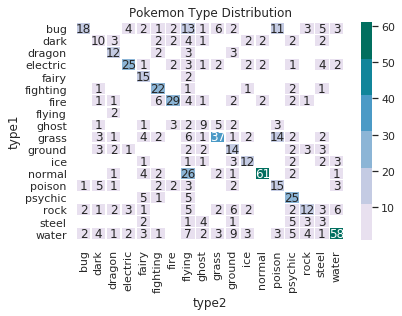

In [155]:
with sns.axes_style('white'):
    ax = sns.heatmap(pivoted_heatmap_df, cmap = heatmap_palette, annot = True, linewidths = 0.5, mask = pivoted_heatmap_df.isnull())
    ax.set_title('Pokemon Type Distribution')

In [135]:
bst_by_evo_stage_df = pkmn_charting_df_final.drop(columns = ['hp', 'attack', 'defense', 'sp. attack', 'sp. defense', 'speed', 'average'])

In [139]:
bst_by_evo_stage_df.total = bst_by_evo_stage_df.total.astype('int64')

In [148]:
sns.set_context('notebook')

Text(0.5, 0.98, 'BST distribution by Primary Type and Stage')

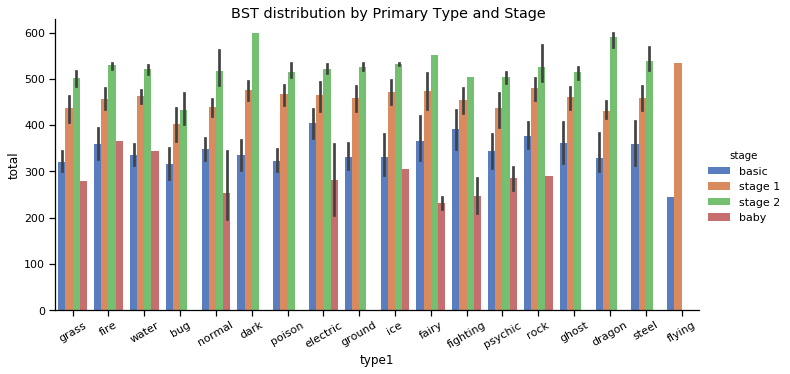

In [158]:
ax2 = sns.catplot(x = 'type1', y = 'total', hue = 'stage', data = bst_by_evo_stage_df, kind = 'bar', palette = 'muted', height = 5, aspect = 2)
ax2.set_xticklabels(rotation = 30)
ax2.fig.suptitle('BST distribution by Primary Type and Stage')

Text(0.5, 0.98, 'BST distribution by Secondary Type and Stage')

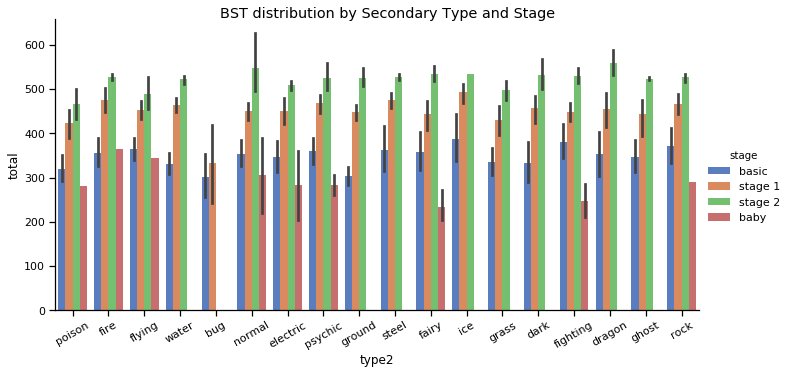

In [157]:
ax3 = sns.catplot(x = 'type2', y = 'total', hue = 'stage', data = bst_by_evo_stage_df, kind = 'bar', palette = 'muted', height = 5, aspect = 2)
ax3.set_xticklabels(rotation = 30)
ax3.fig.suptitle('BST distribution by Secondary Type and Stage')

# stuff above here is mostly final

# stuff below here needs to be edited! (or deleted!)

In [ ]:
#not sure if I need this/am using this!
#Check back and remove if that is not the case!
pkmn_bst_df[55:65].isin({'Pokémon':[]})

In [ ]:
pkmn_bst_df[['Pokemon', 'Variant']] = pkmn_bst_df['Pokemon'].str.split('(',expand=True)

In [ ]:
pkmn_bst_df.head()

In [ ]:
def bulbapedia_form_finder(row):
    if row['Variant'] == None:
        value = row['Pokémon']
    elif "Mega" in row['Variant']:
        value = "Mega"
    elif "Alolan" in row['Variant']:
        value = "Alolan "+row['Pokémon']
    elif "Wormdam" in row['Pokémon']:
        value = row['Pokémon']+row['Variant'].str.split(' ')
    else:
        value = row['Pokémon']
    return value

In [ ]:
pkmn_bst_df['Updated_Name'] = pkmn_bst_df.apply(bulbapedia_form_finder, axis=1)

In [ ]:
#clean all of the string data from trailing spaces introduced in the split above
pkmn_bst_df['Updated_Name'] = pkmn_bst_df['Updated_Name'].str.strip()

In [ ]:
pkmn_bst_df['Pokemon'] = pkmn_bst_df['Pokemon'].str.strip()

In [ ]:
pkmn_bst_df.head()

In [ ]:
pkmn_bst_df[60:69]

In [ ]:
pkmn_bst_df.Updated_Name = pkmn_bst_df.Updated_Name.str.encode('utf-8')

In [ ]:
pkmn_bst_df[60:69]

In [ ]:
pkmn_bst_df[65:75].isin({'Updated_Name':['Meowth']})

Because the second table we're using records all pokemon as only the base pokemon name, we will need a way to intuit the actual pokemon, including forms/regional variants, and match the correct typing.

Should start by looking at the type table and limit to the rows where the nat_dex number is the same as the preceeding nat_dex number (same pokemon).

Will have to know the order and typing for each (Deoxys, Wormadam, Unova Genies)

In [ ]:
#Second Table Download
url_2 = 'https://bulbapedia.bulbagarden.net/wiki/List_of_Pok%C3%A9mon_by_index_number_(Generation_VII)'
page_2 = requests.get(url_2)
tree_2 = html.fromstring(page_2.content)

In [ ]:
tr_elements_2 = tree_2.xpath('//tr')

In [ ]:
#Checks for element length. Helps determine if you scraped more than one table.
#[len(el) for el in tr_elements_2[:12]]
#[len(el) for el in tr_elements_2[-12:-1]]

In [ ]:
pkmn_type_table_rows = []

for el in tr_elements_2:
    if len(el) == 6:
        row = el.text_content()
        pkmn_type_table_rows.append(row)

In [ ]:
#Currently, the type table does not have headers.
#Have to put headers into the dataframe so that I can join data frames.
#Create new list to concatenate with the data list prior to running the table cleaner function.
#Make sure to use accented é character in  "Pokémon"
pkmn_type_table_header = ['Bulb_Index,Nat_Dex,Pokémon,Type1,Type2']

In [ ]:
pkmn_type_table_rows = pkmn_type_table_header+pkmn_type_table_rows

In [ ]:
pkmn_type_df = bulbapedia_table_cleaner(pkmn_type_table_rows)

In [ ]:
pkmn_type_df.head()

In [ ]:
#Promote first row of df to headers
header_row = pkmn_type_df.iloc[0]
pkmn_type_df = pkmn_type_df[1:]
pkmn_type_df.columns = header_row

In [ ]:
pkmn_type_df.head()

In [ ]:
pkmn_type_df[50:59]

The pkmn_type_df does not have type data for Alolan variants of pokemon.

I am not sure what the best solution is. I think it may be to specifically write/append the Alolan type data to the dataframe itself.

In [ ]:
alolan_type_df = pd.DataFrame([[19, 'Alolan Rattata', 'Dark', 'Normal'], 
                              [20, 'Alolan Raticate', 'Dark', 'Normal'], 
                              [26, 'Alolan Raichu', 'Electric', 'Psychic'],
                              [27, 'Alolan Sandshrew', 'Ice', 'Steel'],
                              [28, 'Alolan Sandslash', 'Ice', 'Steel'],
                              [37, 'Alolan Vulpix', 'Ice', 'Ice'],
                              [38, 'Alolan Ninetails', 'Ice', 'Fairy'],
                              [50, 'Alolan Diglett', 'Ground', 'Steel'],
                              [51, 'Alolan Dugtrio', 'Ground', 'Steel'],
                              [52, 'Alolan Meowth', 'Dark', 'Dark'],
                              [53, 'Alolan Persian', 'Dark', 'Dark'],
                              [74, 'Alolan Geodude', 'Rock', 'Electric'],
                              [75, 'Alolan Graveler', 'Rock', 'Electric'],
                              [76, 'Alolan Golem', 'Rock', 'Electric'],
                              [88, 'Alolan Grimer', 'Poison', 'Dark'],
                              [89, 'Alolan Muk', 'Poison', 'Dark'],
                              [103, 'Alolan Exeggutor', 'Grass', 'Dragon'],
                              [105, 'Alolan Marowak', 'Fire', 'Ghost']],
                              columns=['Nat_Dex','Pokémon','Type1','Type2'])

In [ ]:
new_pkmn_type_df = pkmn_type_df.append(alolan_type_df, ignore_index=True, sort=False)

In [ ]:
new_pkmn_type_df.Pokémon = new_pkmn_type_df.Pokémon.str.encode('utf-8')

In [ ]:
new_pkmn_type_df.dtypes

In [ ]:
new_pkmn_type_df

In [ ]:
pkmn_full_df = pd.merge(pkmn_bst_df, new_pkmn_type_df, left_on='Updated_Name', right_on='Pokémon')

In [ ]:
#pkmn_full_df = pkmn_bst_df.merge(new_pkmn_type_df, left_on='Updated_Name', right_on='Pokémon')

In [ ]:
#pkmn_full_df = pd.merge(pkmn_bst_df, new_pkmn_type_df, left_on='Updated_Name', right_on='Pokémon')

In [ ]:
#merge is only returning rows with matches.
#Excludes Mega Pokemon (should be the correct thing to do).
#However, need to check the dex numbers and see which columns were actually dex numbers and which were indexes.
pkmn_full_df

In [ ]:
pkmn_full_df[50:59]

In [ ]:
pkmn_full_df.Pokémon_x = pkmn_full_df.Pokémon_x.str.encode('utf-8')

In [ ]:
pkmn_full_df[pkmn_full_df.Pokémon_y.isin(["Alolan Diglett"])]

In [ ]:
pkmn_full_df.index

In [ ]:
pkmn_full_df.Nat_Dex = pd.to_numeric(pkmn_full_df.Nat_Dex)

In [ ]:
pkmn_full_df

In [ ]:
# at turtwig, index switches to being 2 behind (index = 385, Dex = 387)
# at Burmy/Mothim (Nat_Dex = 412,414), index switches to being 3 behind (index = 411, Dex = 414)
# by Drampa (Nat_Dex = 780), index is 14 behind (index = 766, Dex = 780)
# Offset stays at 14 til end of pokemon. See Melmetal (index = 795, Dex = 809)
pkmn_full_df.query('Nat_Dex != (index+1)')

In [ ]:
pkmn_full_df[380:389]

In [ ]:
#Error comes from the merging with special "forme" pokemon.
#Deoxys is missing from the pkmn_full_df because it 
#is recorded as "Deoxys (Normal Forme)" in the bst_df and "Deoxys" in the type_df
pkmn_bst_df[440:459]

Comparing pokemon by type alone is not a good method for determining avevrage stats. Pokemon species go through the process of evolution to become stronger. Naturally, the higher a pokemon's evolutionary stage the higher its stats are.

I could not find a satisfactory dataset of pokemon by their evolutionary stage, so I composed my own in .csv format. The stages used are: basic, stage 1, stage 2, baby, legendary, mega, and ultra beast.

In [ ]:
stages_raw = open("pokemon stages.csv", "r")

In [ ]:
stages_read = stages_raw.read()

In [ ]:
stages_split = stages_read.split("\n")

In [ ]:
stages_split

In [ ]:
def makes_list_of_lists(input_lst):
    output_list = []

    for el in input_lst:
        list_split = el.split(",")
        output_list.append(list_split)
    return output_list

In [ ]:
pkmn_stages_data = makes_list_of_lists(stages_split)

In [ ]:
pkmn_stages_df = pd.DataFrame(pkmn_stages_data)

In [ ]:
pkmn_stages_df.head()

In [ ]:
#Promote first row of df to headers
header_row = pkmn_stages_df.iloc[0]
pkmn_stages_df = pkmn_stages_df[1:]
pkmn_stages_df.columns = header_row

In [ ]:
pkmn_stages_df.dtypes

In [ ]:
pkmn_stages_df.Pokemon = pkmn_stages_df.Pokemon.str.encode('utf-8')

In [ ]:
pkmn_stages_df

In [ ]:
pkmn_final_df = pd.merge(pkmn_full_df, pkmn_stages_df, how='left', left_on='Pokémon_x', right_on='Pokemon')

In [ ]:
pkmn_final_df

In [ ]:
pkmn_final_df[50:59]

In [ ]:
not_legendary_df = pkmn_final_df[(pkmn_final_df.Stage != "legendary") & (pkmn_final_df.Stage != "ultra beast")]

In [ ]:
not_legendary_df

In [ ]:
not_legendary_df.drop(columns = ['Pokémon_x', 'Average', 'Variant', 'Bulb_Index', 'Pokémon_y', 'dex #', 'Pokemon'])

In [ ]:
not_legendary_df.Total = pd.to_numeric(not_legendary_df.Total)

In [ ]:
t1_stage_bst_mean_df = not_legendary_df.groupby(['Type1', 'Stage']).mean()

In [ ]:
t1_stage_bst_mean_df 

In [ ]:
pivoted_df = t1_stage_bst_mean_df.pivot_table(values='Total', index='Type1', columns='Stage')

In [ ]:
pivoted_df

In [ ]:
pivoted_df.reset_index()

In [ ]:
t1_stage_bst_mean_df.reset_index()

In [ ]:
t1_stage_bst_mean_df.plot.bar(stacked=True)

In [ ]:
pyplot.bar(x=t1_stage_bst_mean_df.Index[0:2],y=t1_stage_bst_mean_df.Total)

Start of Nathan's actual work on plotting things.
Don't mess with code above, that's not a good plot.

In [ ]:
#pyplot.figure(figsize=(5,5))
#pyplot.bar(x=)

In [ ]:
pivoted_df.plot(kind='bar', figsize=(12,10), title='Average BST distribution by Primary Type')